# Lab 08

## More Classification with Scikit Learn

Last week we used the Naive Bayes multinomial classifier, getting 93% accuracy on our author classification task.

In [ ]:
import pandas as pd
path = 'https://raw.githubusercontent.com/organisciak/Text-Mining-Course/master/data/contemporary_books/'
data = pd.read_csv(path + 'contemporary.csv', encoding='utf-8').set_index('book')
info = pd.read_csv(path + 'contemporary_labels.csv', encoding='utf-8')

train_data = data.iloc[0:15]
train_labels = info.iloc[0:15]
test_data = data.iloc[15:]
test_labels = info.iloc[15:]

Other classifiers are available from SciKit Learn using the same interface, including support vector machines ([linear_model.SGDClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)) and Logistic Regression: ([linear_model.LogisticRegression()](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)). They have many more options to customize them; for now, you can focus on the default options. Out of the box, you use them in exactly the same way that you used MultinomialNB last week.

**Q1**: Replacing the Naive Bayes classifier with Logistic Regression, what accurance do you get on the same train/test task as in Lab 8? Don't forget to start with `from sklearn import linear_model`.

[0.0, 0.25, 0.5, 0.625, 0.6875, 0.875, 0.9375, 1]

**Q2**: Try the SVM classifier. Re-run your code initializing, fitting, and scoring a couple of times. What happens to the accuracy?

## Clustering with Scikit Learn

To cluster in Scikit Learn, you need the same type of data as in classification: a set of vectors with term counts, one vector per document.

However, clustering is usually done when you don't know a real set of classes, so you do not supply labels.

Here is how you might learn a set of clusters with K-Means from the Atwood/Grisham/King data that we already have loaded:

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)

The cluster groups that were assigned are available from `kmeans.labels_`:

In [ ]:
kmeans.labels_

array([1, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 0])

Remember that K-Means starts with a random initialization and can get stuck in different configurations, so your groups may not be identical.

**Q3**: You want to view the cluster groups alongside the information for the books that are held in info. Show the code to add a `group` column to `info`, set to the kmeans label information, and to sort the values by that column. It will look something like this: 

![](../images/lab8-group-column.png)

In my K-Means clustering for 3 groups, I ended up with one group that only had one book: *The Stand*.

This makes sense, because *The Stand* is loooong, and I'm using raw term frequencies. So, every word will show up a lot more, not because that word is more prominant in that book, but because there are some many more words being used overall. On a graph, *The Stand* would float far afield of all the other books.

We already learned how to correct raw frequency counts: our old friend tf-idf! We learned about softened the scaling of counts (sublinear tf) and weighing words relative to their prevalence in the language (idf). Scikit Learn offers both of those under `sklearn.feature_extraction.text.TfidfTransformer`.

**Q4**: Using the documentation for TfidfTransformer (and maybe help from your classmates), determine how to transform the document-term data used above, with both sublinear tf scaling and inverse-document-frequency. Share your code.

Hint: if you did it right, the value for the first word of the first document for your new variable (i.e. `data_tfidf[0,0]`) should be around `0.0063`.

**Q5**: Try clustering on the tf-idf transformed data, using the same `n_clusters=3` k-means options as before. How do the results look different? (tip, the sorting from *Q3* might help you look at the data).

So far we have tested clustering around known information, but the useful part of unsupervised learning is in finding new patterns. What if you cluster into two clusters? 20? What patterns do we see?

**Q6**: Cluster data_tfidf to 2 clusters and describe how the books cluster.

## More Techniques

### An easier to interpret classifier: decision tree

Here is an example of a decision tree classifier, which identifies discriminatory features out of the larger set, and uses those features to make the important classification decisions.

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data, info['author'])

Visualization is trickier because you need to install a separate library; details can be found in the Scikit Learn docs. Here is an example of what a decision tree might look like:

![](../images/decisiontree.png)

(This tree was trained with the arguments `splitter='random', criterion='entropy', min_samples_split=0.5`.)

This example uses all of the data, because we're not testing it on anything, but it is possible to use in the same way as earlier classifiers, with `clf.fit(train_data)` and `clf.predict(test_data)`.

Decision Trees are easy to interpret, but tend to be most interesting for tasks with many classes but few features. For text mining, we usually have really large feature sets, because each word in our vocabulary is a feature.

Here is a non-text example that I trained on the survival of Titanic passengers.

In [ ]:
df = pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/datasets/Titanic.csv', na_values='*').dropna()
# Make the passenger class column numeric (e.g. 1,2,3) instead of strings (e.g. '1st', '2nd', '3rd')
df['PClass'] = df['PClass'].apply(lambda x: float(x[0]))

clf = tree.DecisionTreeClassifier()
clf = clf.fit(df[['PClass', 'Age', 'SexCode']], df['Survived'])

The decision tree for this classifier is [posted as a PDF](../images/titanic.pdf). Reading from the top:

- By default, assume that the passenger didn't survive.
- The most important indicator of survival is gender. If the gender is '0' (Male), assume the person died, else assume they survived.
- Amongst men, Age <= 12 was an indicator of survival. Amongst women, the most important next differentior was whether they were in first class (survived) or third (did not survive).

And so on. The zoomed out view shows the grimness: men on left, women on right, dark orange is likely non-survival while dark blue is likely survival.

![](../images/titanic-zoomed-out.png)

### Agglomerative Clustering

Here is an example of agglomerative cluster - 'bottom-up' clustering:

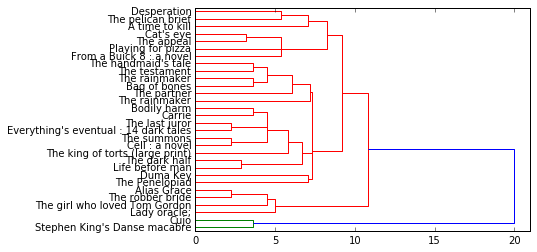

In [ ]:
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Learn clusters
model = AgglomerativeClustering()
model = model.fit(data_tfidf.toarray())

# Visualize the clusters
Z = linkage(model.children_)
graph = dendrogram(Z, orientation='right', labels=info['title'].values)

These clusters are visualized using a dendrogram. The lines connect similar books or clusters, and the depth of the lines shows how similar those two nodes are. For example the cluster of _Cujo_ and _Dance macabre_ is very dissimilar from the cluster of all the other books, which is why the blue line extends so far to the right when connecting them.